In [5]:
import torch
import os
from PIL import Image
from lavis.models import load_model_and_preprocess
import mediapy as media
from pathlib import Path
import numpy as np
import time
import json
from tqdm import tqdm

C:\Users\KevinWu\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_feature_extractor", model_type="base", is_eval=True, device=device)

In [7]:
db_root = Path('D:\\temp\\database_blip_avg\\images_hair_0801_mclip').absolute()

# Construct Database

In [8]:
caption = "gloves"
text_input = txt_processors["eval"](caption)

In [9]:
metadata = json.load(open(db_root / 'metadata.json')) 

In [10]:
def avg_img(img, average=False):
    features_image = [None] * len(img)
    for i in range(len(img)):
        image = vis_processors["eval"](img[i]).unsqueeze(0).to(device)
        sample = {"image": image, "text_input": [text_input]}
        features_image[i] = model.extract_features(sample, mode="image")
        features_image[i] = features_image[i].image_embeds_proj.cpu().numpy()
        features_image[i] = features_image[i][:,0,:]
        #features_image[i] /= np.linalg.norm(features_image[i], axis=1, keepdims=True)
    if average:
        features_image = np.concatenate([features_image[i] for i in range(len(img))])
        features_image = features_image.mean(axis=0, keepdims=True)
    return features_image
    

In [11]:
def load_db(encode=False):
    db = {}
    for name in tqdm(metadata):
        img_path = Path(db_root / name)
        img_num = len(list(img_path.glob('*.jpg'))) 
        imgs = [Image.open(img_path / f'{i:01d}.jpg') for i in range(img_num)]
        if encode:
            db[name] = {
                'latent_image': avg_img(imgs, average=True),
                # 'latent_filename': clip_cosine.encode_text(img_path.stem),
                'image': imgs,
            }
        else:
            db[name] = {
                'latent_image': np.load(str(img_path / 'latent_image.npy')),
                # 'latent_filename': clip_cosine.encode_text(img_path.stem),
                'image': imgs,
            }
    return db

In [12]:
db = load_db(encode=False)

100%|██████████| 200/200 [00:00<00:00, 778.69it/s]


In [55]:
for name, v in db.items():
    #if (db_root / name / 'latent_image.npy').exists():
        #continue
    # v['image'][0].save(str(db_root / name / 'preview.gif')) //單圖
    media.write_video(str(db_root / name / 'preview.gif'), [np.array(x) for x in v['image']], codec='gif', fps=1,)
    np.save(str(db_root / name / 'latent_image.npy'), v['latent_image'])
    #for i in range(len(v)-1):
        #np.save(str(db_root / name / f"latent_image{i}.npy"), v[f"latent_image{i}"])

# Search

In [ ]:
#show_numbers = 60
#caption = "braid"
#text_input = txt_processors["eval"](caption)
#for name in tqdm(metadata):
#    img_path = Path(db_root / name)
#    imgs = Image.open(img_path / '0.jpg')
#    image = vis_processors["eval"](imgs).unsqueeze(0).to(device)
#    sample = {"image": image, "text_input": [text_input]}
#    features_text = model.extract_features(sample, mode="text")
#    features_text = features_text.text_embeds_proj.cpu().numpy()
#    features_text = features_text[:,0,:]
#    #features_text /= np.linalg.norm(features_text, axis=1, keepdims=True)
#    #print(features_text[0].shape)
#    break

In [25]:
show_numbers = 60
caption = "braid"
text_input = txt_processors["eval"](caption)
sample = {"image": 'no', "text_input": [text_input]}
features_text = model.extract_features(sample, mode="text")
features_text = features_text.text_embeds_proj.cpu().numpy()
features_text = features_text[:,0,:]

In [26]:
def get_latents():
    name = list(db.keys())
    latents = np.concatenate([db[i]['latent_image'] for i in name])
    return name, latents

In [27]:
def search(target_latent, top_k=60):
    name, latents = get_latents()
    top_k = min(top_k, len(name))
    dists = (latents@target_latent.T).flatten()
    top_idx = np.argpartition(dists, len(dists)-top_k)[-top_k:]
    similarities = {
        k: v
        for k, v in zip([name[i] for i in top_idx], dists[top_idx])
    }
    #similarities = {
        #name[i]: dists[i]
        #for i in top_idx
    #}
    sorted_contents = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return sorted_contents

In [28]:
start = time.time()
sorted_contents = search(features_text, show_numbers)
#print(type(sorted_contents))
end = time.time()
print(end-start)


0.0


In [29]:
candidates = {}
for name, s in sorted_contents[:show_numbers]:
    candidates[f'Similarity: {s:.4f}'] = db[name]['image'][0]


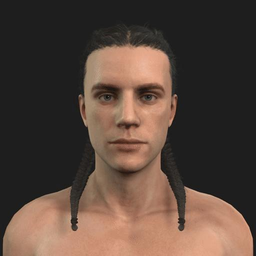
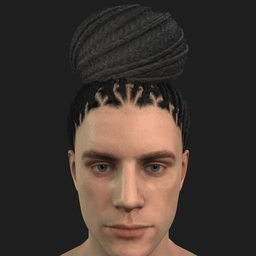
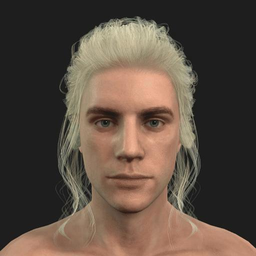
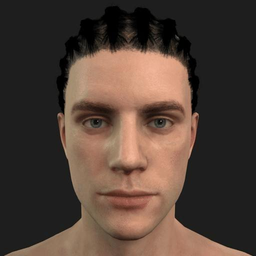
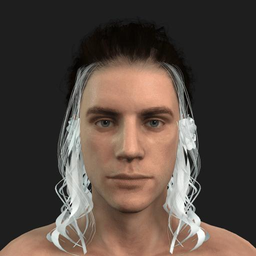
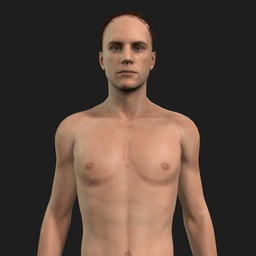
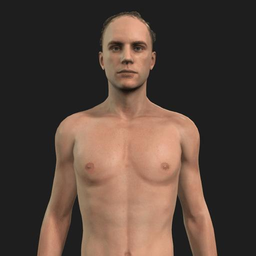
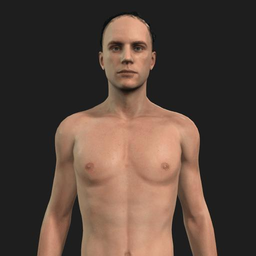
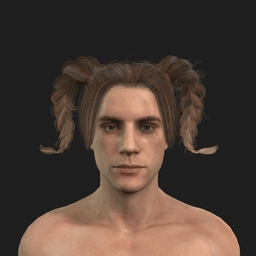
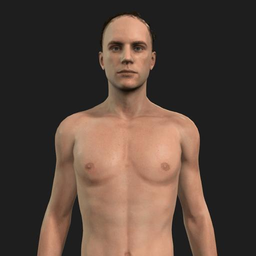
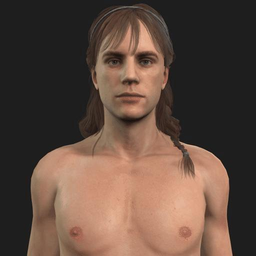
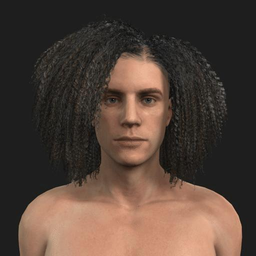
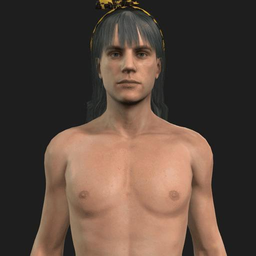
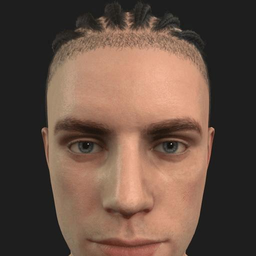
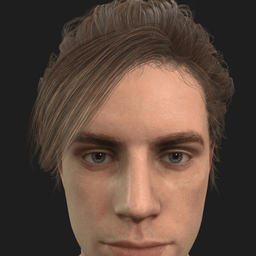
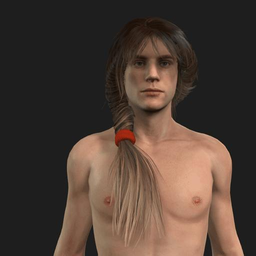
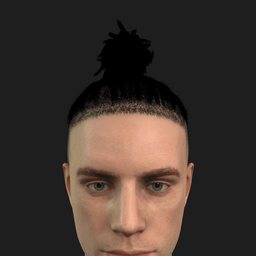
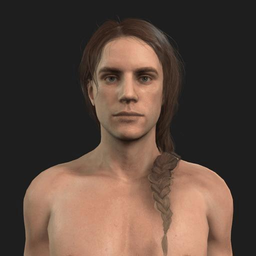
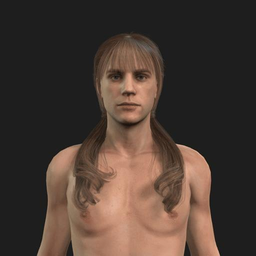
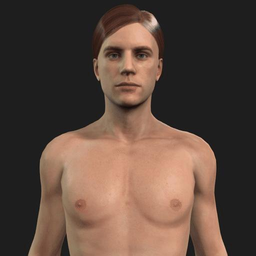
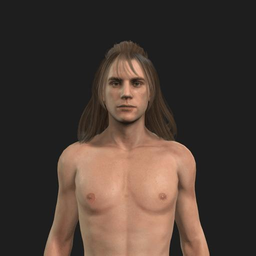
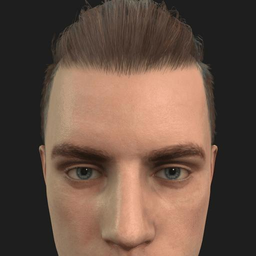
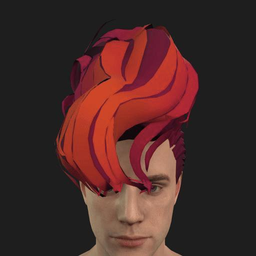
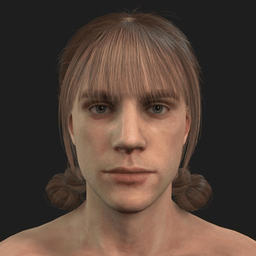
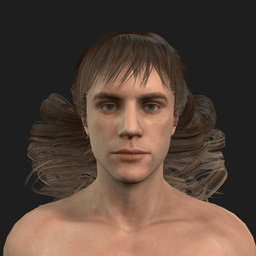
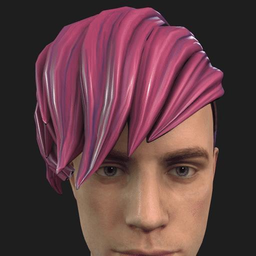
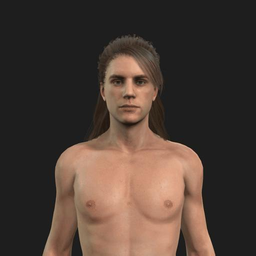
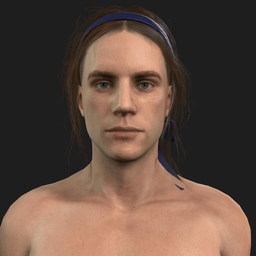
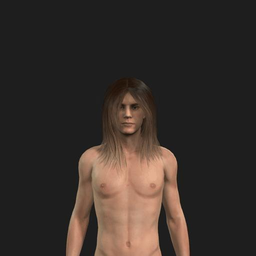
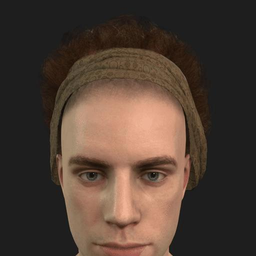
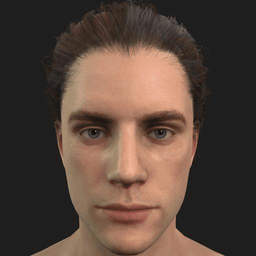
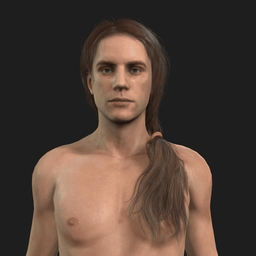
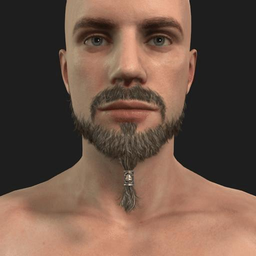
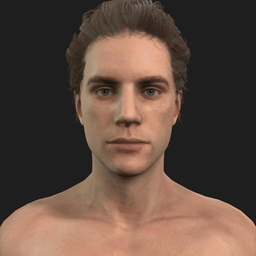
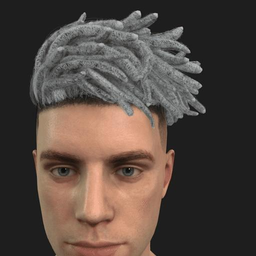
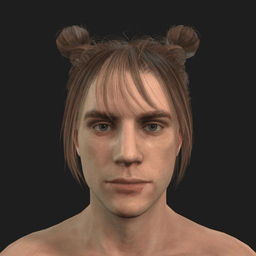
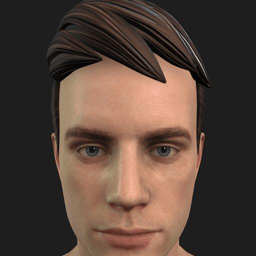
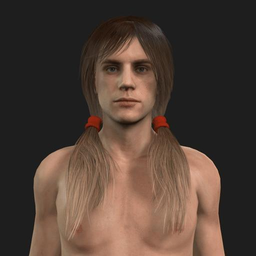
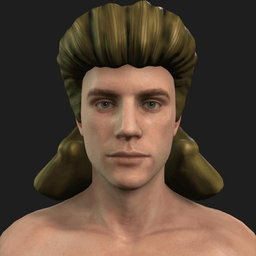
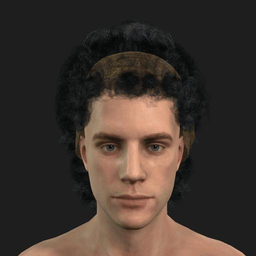
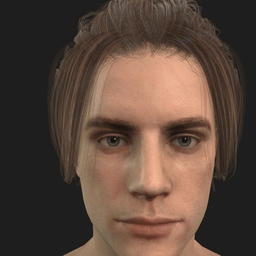
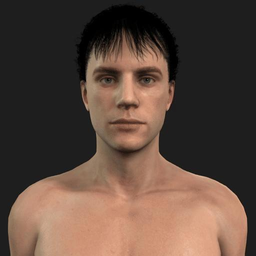
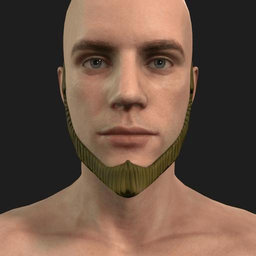
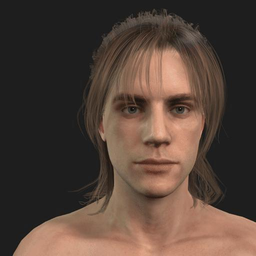
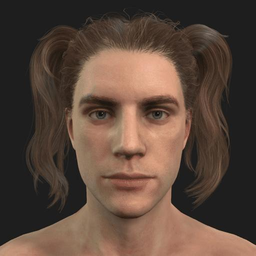
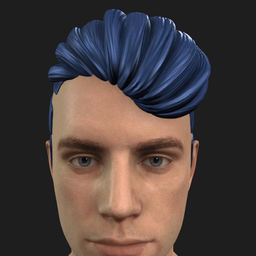
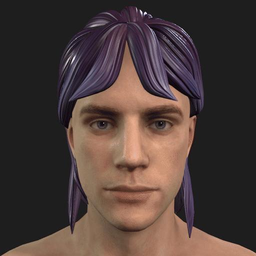
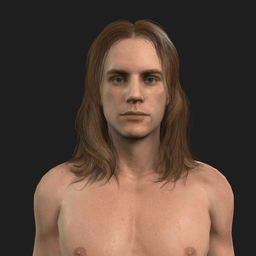
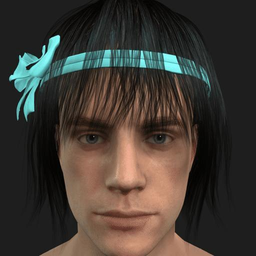
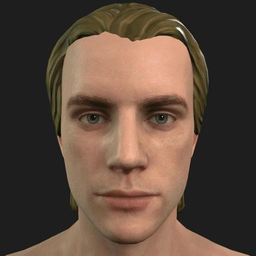
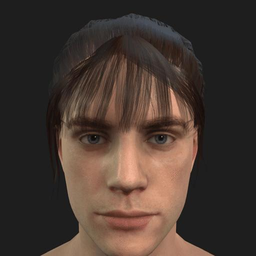
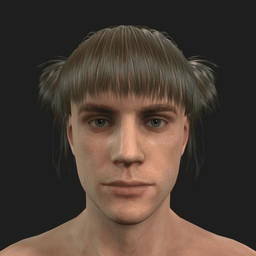
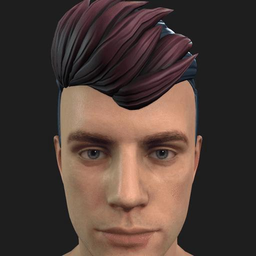
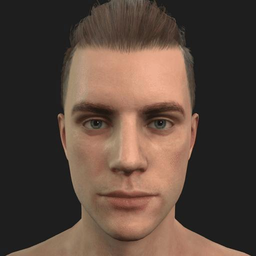

In [30]:
media.show_images(candidates, width=256, columns=5)